In [80]:
%load_ext autoreload
%autoreload 2

%pylab inline
import sys, fiona
sys.path.append("../")
sys.path.insert(0,"/home/luca/Code/topojson.git/")
import mappy as mpy
import geopandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# interesting link for checking overlaps
https://medium.com/@achm.firmansyah/an-approach-for-checking-overlaps-and-gaps-in-polygons-using-geopandas-ebd6606e7f70

In [81]:
infile = "/home/luca/Code/mappy.git/input_data/build_map.gpkg"
layer_name  = "geomap"
column_name="unit_name"

# infile = "/home/luca/Code/mappy.git/input_data/test_map.gpkg"
# layer_name  = "test_map"
# column_name="name"


infile = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01.gpkg"
layer_name= "subregion_fixed"
column_name="Unit_Code"


# infile = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01_2.gpkg"
# layer_name= "subregion_fixed"
# column_name="Unit_Code"



In [82]:
import geopandas as gpd

In [83]:
fiona.listlayers(infile)

['subregion_fixed']

In [84]:
polygons = gpd.read_file(infile, layer=layer_name)

polygons = mpy.explode_multipolygons(polygons)
polygons = mpy.remove_null_geometries(polygons) 
polygons =  mpy.remove_truly_duplicated_geometries(polygons)

polygons.reset_index(inplace=True)

In [85]:
polygnos = polygons.buffer(0)

/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/luca/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

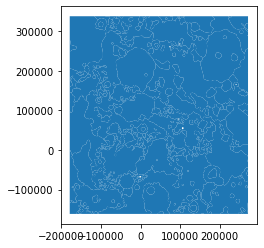

In [86]:
polygons.plot()

In [87]:
minx, miny, maxx, maxy = polygons.total_bounds

half_rangex = (maxx-minx)/2
half_rangey = (maxy-miny)/2
s = 1/(maxx-minx)

center = (minx, miny)
pols = polygons.translate(-(minx+half_rangex), -(miny+half_rangey))

minx, maxx, miny, maxy = pols.total_bounds
s = 1/(half_rangex*2)
pols2 = pols.scale(s, s, s, origin=(0,0))
pols2

0      POLYGON ((0.31393 -0.30025, 0.31747 -0.30096, ...
1      POLYGON ((-0.32923 0.52391, -0.32609 0.52342, ...
2      POLYGON ((-0.01687 0.40251, -0.01418 0.40308, ...
3      POLYGON ((-0.33846 0.09280, -0.33663 0.09243, ...
4      POLYGON ((0.50000 -0.31026, 0.50000 -0.34200, ...
                             ...                        
254    POLYGON ((-0.36455 0.55438, -0.30243 0.55438, ...
255    POLYGON ((-0.05074 0.55438, -0.00474 0.55438, ...
256    POLYGON ((0.50000 0.02842, 0.50000 -0.00588, 0...
257    POLYGON ((0.38904 0.55438, 0.40601 0.55438, 0....
258    POLYGON ((0.11687 0.55438, 0.13592 0.55438, 0....
Length: 259, dtype: geometry

In [88]:
polygons = pols2

In [89]:
polygons.total_bounds

array([-0.5       , -0.55438228,  0.5       ,  0.55438228])

In [90]:
intersections = []

import itertools, shapely
from mappy.booleans import recompute_pols

# def filter_polygons(data):
#     GC = shapely.geometry.GeometryCollection
#     if isinstance(data, shapely.geometry.Polygon):
#         return data
#     else:
#         pols = [d for d in data if isinstance(d,shapely.geometry.Polygon)]
#         return shapely.ops.cascaded_union(pols)

    
def filter_polygons(data):
    if isinstance(data, shapely.geometry.Polygon):
        return data
    elif isinstance(data, (shapely.geometry.LineString,shapely.geometry.MultiLineString, shapely.geometry.Point )):
        return None
    else:
        pols = [d for d in data if isinstance(d,shapely.geometry.Polygon)]
        if len(pols) == 0:
            return None
        if len(pols)==1:
            return pols[0]
        else:
            return shapely.ops.cascaded_union(pols)

def fix_intersection(polygons, id1, id2):
    a = polygons.geometry[id1]
    b = polygons.geometry[id2]
    
    if not a.is_valid or not b.is_valid:
        print("invalid polygon")
        return
    
    try:
        inter = a.intersection(b)
    except:
        return
    
    inter = filter_polygons(inter)
    if inter is None:
        return None
    
    if not inter.is_valid:
        print("invalid ")
        return
    
#     print(inter)
    try:
        newa, newb = recompute_pols(a,b)
    except:
        print("Cannot fix polygons")
        return a,b
    
#     inter = a.intersection(b)
#     newa = filter_polygons(a.union(inter))
#     newb = filter_polygons(b-inter)
#     print(type(newa))

#     if isinstance(newa, shapely.geometry.MultiPolygon) or isinstance(newb, shapely.geometry.MultiPolygon):
#         newb = filter_polygons(b.union(inter))
#         newa = filter_polygons(a.difference(inter))
        
    
    
    polygons.geometry[id1] =  filter_polygons(newa)
    polygons.geometry[id2] =  filter_polygons(newb)
    
    return newa, newb, inter
    
    
intersections = []
counter = 0
for id1, id2 in itertools.combinations(list(polygons.index.values), 2):
    pol1 = polygons.geometry[id1]
    pol2 = polygons.geometry[id2]
    
    if pol1.intersects(pol2):
        out = fix_intersection(polygons, id1, id2)
        if out is not None:
            intersections.append([pol1, pol2, out])
            polygons.to_file("cleared.gpkg", driver="GPKG" , layer=f"cleared_{str(counter)}")
            counter+=1
                
print(counter)


    
    


                

Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons
Cannot fix polygons


In [91]:
polygons.to_file("cleared.gpkg", driver="GPKG" , layer="cleared3")

In [12]:
for id, (p1, p2, (a,b,c)) in enumerate(intersections):
    if isinstance(a, shapely.geometry.MultiPolygon):
        print(id)

In [36]:
asgpd = geopandas.GeoDataFrame(geometry=[p1, p2])


In [37]:
asgpd.to_file("pols.geojson", driver='GeoJSON')

In [39]:
p1, p2, (a,b,c) = intersections[0]

int = p1.intersection(p2)
e = p1.union(int)
e2 = p2.difference(int)



In [40]:
# from scikit.geometry import Polygon

In [41]:
np.array(e2.exterior)

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[ 0.12679023, -0.48567818],
       [ 0.23897383, -0.18596377],
       [ 0.24136479, -0.18576243],
       [ 0.45703454,  0.48483572],
       [ 0.45697177,  0.48483462],
       [ 0.31213142,  0.0379107 ],
       [ 0.45724516,  0.48567818],
       [ 0.5       ,  0.44545072],
       [ 0.48841618,  0.39595619],
       [ 0.12679023, -0.48567818]])

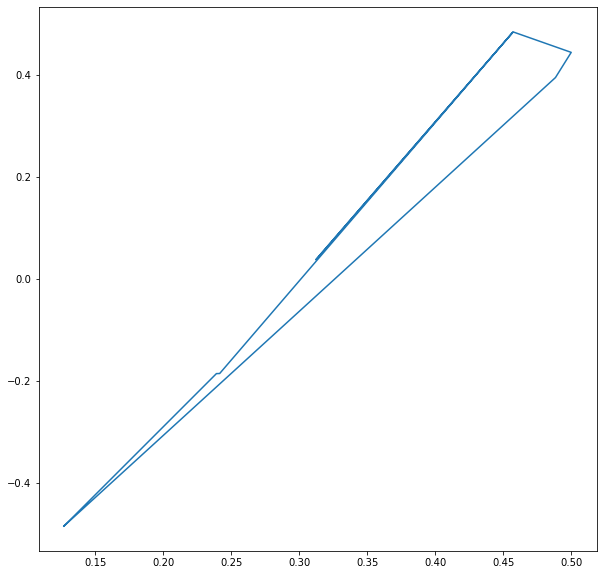

In [42]:
figure(figsize=(10,10))
plot(*np.array(e2.exterior).T)

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


(-0.4, 0.0)

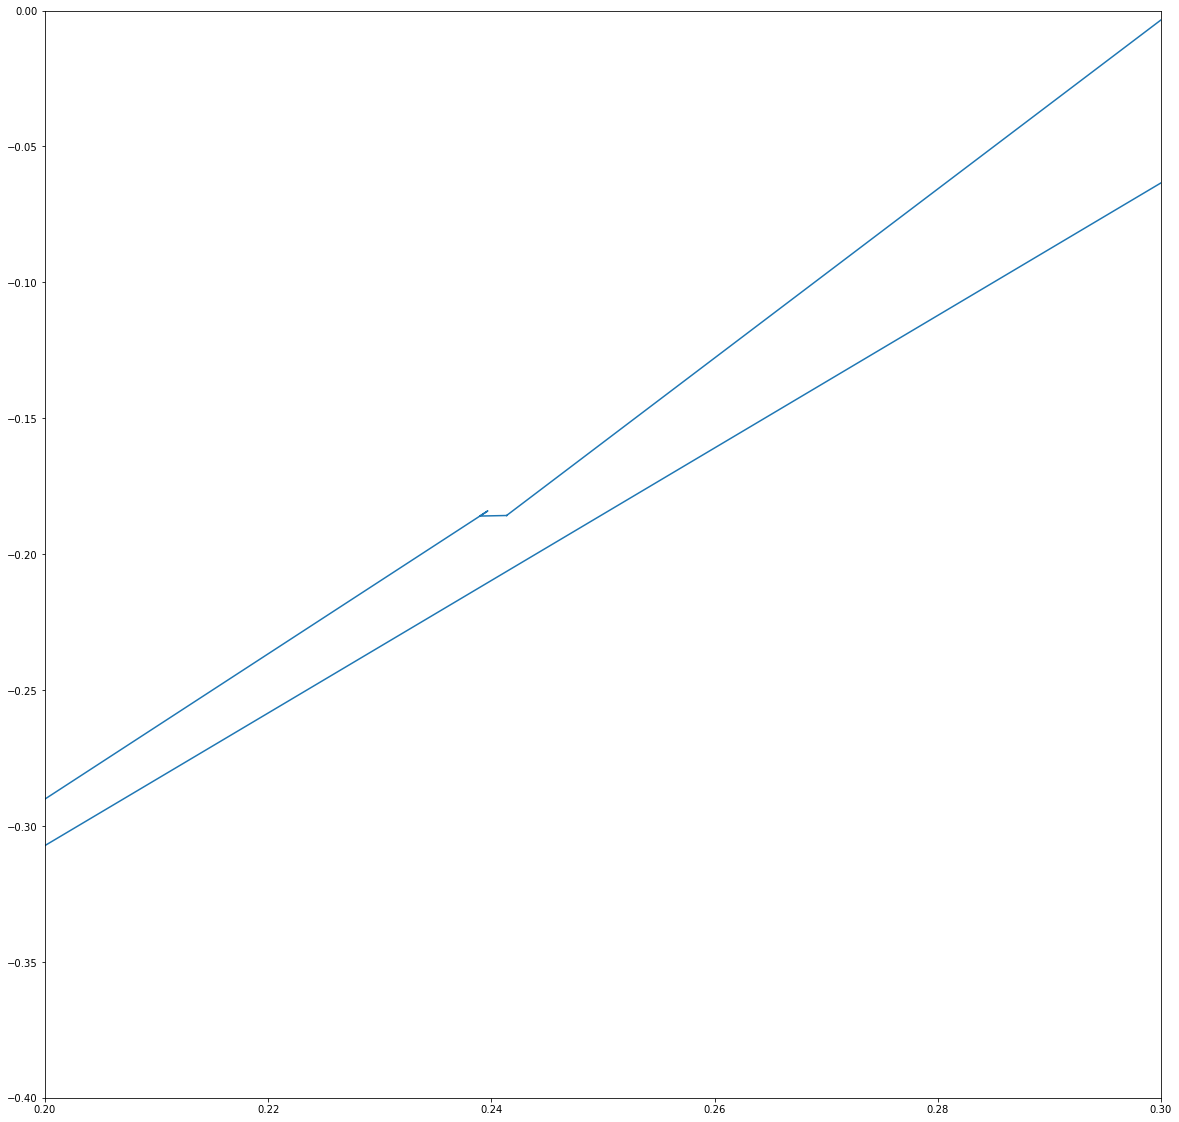

In [73]:
from mappy.booleans import intersect, union, difference, shapely_to_clipper, clipper_to_shapely
int = intersect(shapely_to_clipper(p1), shapely_to_clipper(p2))
e = union(shapely_to_clipper(p1),int)
e2 = clipper_to_shapely(difference(int, shapely_to_clipper(p2)))

figure(figsize=(20,20))
plot(*np.array(e2.exterior).T)
xlim(0.2, 0.3)
ylim(-0.4, 0)

In [68]:
from shapely.validation import explain_validity
explain_validity(e2)

'Self-intersection[0.238973833664249 -0.185963768973992]'

In [73]:
ii = filter_polygons(p1.intersection(p2))
mp = p2.union(ii)

type(mp)

shapely.geometry.polygon.Polygon

In [53]:
myi = filter_polygons(p1.intersection(p2))

In [54]:
type(p1.union(myi))

shapely.geometry.multipolygon.MultiPolygon

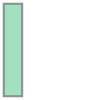

In [101]:
i = p1.intersection(p2)
i

In [41]:
aa = p1.union(i)

In [42]:
bb = p2.difference(i)

In [44]:
aa.union(bb) == p1.union(p2)

True

In [1274]:
geopandas.GeoDataFrame(geometry=[i[2] for i in intersections]).to_file("init_intersections.gpkg", driver="GPKG", layer="inter")

<AxesSubplot:>

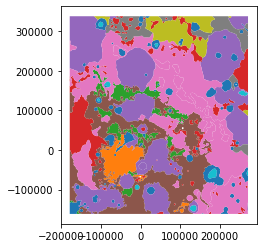

In [200]:
polygons.plot(column=column_name)

In [201]:
polygons.to_file("dissolved.gpkg", layer="dissolved", driver="GPKG")

In [202]:
aspd = mpy.generate_label_points(polygons)

TypeError: Only polygons are supported

In [203]:
aspd = mpy.transfer_polygons_fields_to_points(aspd, polygons)

NameError: name 'aspd' is not defined

NameError: name 'aspd' is not defined

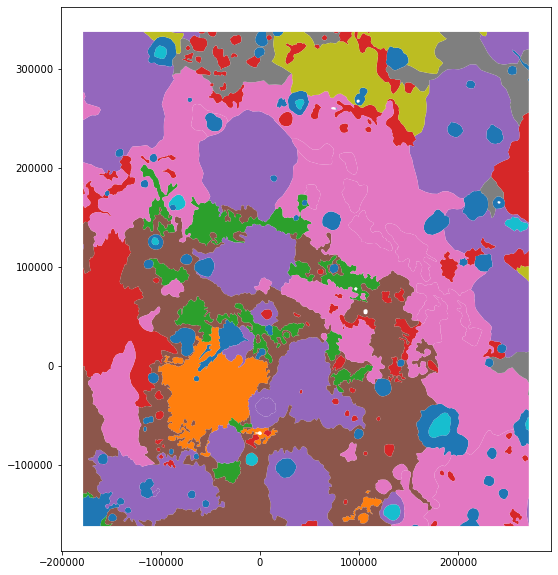

In [204]:
figure(figsize=(10,10))
polygons.plot(column=column_name,ax=gca())
aspd.plot(ax=gca(), color="white", markersize=35)
aspd.to_file("indicator_points.gpkg", driver="GPKG", layer="points")

In [1280]:
mpy.check_validity_of_geometries(polygons)

In [1281]:
import topojson 

tj = topojson.Topology(polygons,prequantize=False,topoquantize=True, shared_coords=False, toposimplify=False, presimplify=False)
# tj = tj.toposimplify(1).topoquantize(1e6)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (-6292.94 -69581.4, -6500.47 -69498.6) and LINESTRING (-6500.47 -69498.6, -6500.47 -69498.6) at -6500.467868788066 -69498.634381929151
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (218395 176774, 218395 176774) and LINESTRING (218395 176774, 218395 176774) at 218395.25589228648 176773.5638798188
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (263164 308346, 262297 309959) and LINESTRING (262297 309959, 262297 309959) at 262296.62612529157 309958.60615120124
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (187551 139761, 187551 139761) and LINESTRING (187551 139761, 187551 139761) at 187550.84260184495 139760.79698821114
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (-88645.3 305982, -88736.9 305231) and LINESTRING (-88976 303274, -88736.9 305231)

In [1282]:
topojson.Topology?

Init signature:
topojson.Topology(
    data,
    topology=True,
    prequantize=True,
    topoquantize=False,
    presimplify=False,
    toposimplify=False,
    shared_coords=True,
    prevent_oversimplify=True,
    simplify_with='shapely',
    simplify_algorithm='dp',
    winding_order='CW_CCW',
)
Docstring:     
Returns a TopoJSON topology for the specified geometric object. TopoJSON is an 
extension of GeoJSON providing multiple approaches to compress the geographical 
input data. These options include simplifying the linestrings or quantizing the 
coordinates but foremost the computation of a topology.

Parameters
----------
data : _any_ geometric type
    Geometric data that should be converted into TopoJSON 
topology : boolean
    Specifiy if the topology should be computed for deriving the TopoJSON. 
    Default is `True`.
prequantize : boolean, int
    If the prequantization parameter is specified, the input geometry is 
    quantized prior to computing the topology, the return

In [1283]:
len(tj.output["arcs"])

1493

In [1284]:
asgdf =  tj.to_gdf()

In [1285]:
asgdf.to_file("topojsoned.gpkg", layer="topojsoned", driver="GPKG")

In [1286]:

# arc_ids = tj.output["objects"]["data"]["geometries"][4]["arcs"][0]


# for id in arc_ids:
#     if id < 0:
#         id = -id-1
#     pts = tj.output["arcs"][np.abs(id)]
#     pts = np.cumsum(np.array(pts), axis=0)
#     plot(*pts.T)

In [1310]:
len(tj.output["arcs"])

1493

In [1287]:
import topojson, copy
from topojson.ops import np_array_from_arcs


def extract_numpy_arcs(topology):
    t=False
    if "transform" in topology.output.keys():
        t = True
        s = np.array(topology.output["transform"]["scale"])
        t = np.array(topology.output["transform"]["translate"])
    top = topology._resolve_coords(topology.output)
    np_arcs = np_array_from_arcs(top["arcs"])
    if t:
        out = topojson.ops.dequantize(np_arcs, s, t)
    else:
        out = np_arcs

    out = [o[~np.isnan(o).any(axis=1)] for o in out]
    
    return out

out = extract_numpy_arcs(tj)

<ipython-input-1288-955a0c5bd73a>:3: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  glines = [asLineString(e) for e in out]


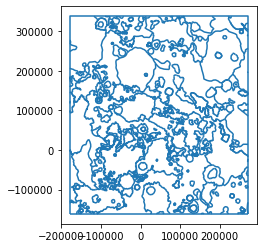

In [1288]:
import shapely
from shapely.geometry import asLineString
glines = [asLineString(e) for e in out]
asg = geopandas.GeoDataFrame(geometry=glines)
asg.plot()
show()

asg.to_file("lines.gpkg", layer="lines", driver="GPKG")

In [1289]:
def reorder_points( points):
    startid = np.argmax(points[:,1])
    ids = np.arange(len(points))
    if startid != 0:
        out = np.row_stack([points[startid:, :], points[1:startid, :], points[startid, :]])
        ids = np.concatenate([ids[startid:], ids[1:startid], [ids[startid]]])
        
        return out, ids
    else:
        return points, ids
    
# a = np.random.randn(10,2)
# a[-1:] = a[0]

# print(a)
# reorder_points(a)

[[ 1.01567745 -0.75005481]
 [ 1.32740412 -0.49419332]
 [-0.41099023 -0.71258542]
 [ 0.21769176 -0.32336864]
 [-0.0463526   0.27408806]
 [ 0.5804946  -0.21407073]
 [ 0.34272781  0.20960311]
 [ 1.31421401  0.7438521 ]
 [-0.13472647 -0.12055653]
 [ 1.01567745 -0.75005481]]


(array([[ 1.31421401,  0.7438521 ],
        [-0.13472647, -0.12055653],
        [ 1.01567745, -0.75005481],
        [ 1.32740412, -0.49419332],
        [-0.41099023, -0.71258542],
        [ 0.21769176, -0.32336864],
        [-0.0463526 ,  0.27408806],
        [ 0.5804946 , -0.21407073],
        [ 0.34272781,  0.20960311],
        [ 1.31421401,  0.7438521 ]]),
 array([7, 8, 9, 1, 2, 3, 4, 5, 6, 7]))

In [1290]:


import attr
@attr.attrs(eq=False)
class Arc:
    points = attr.ib(repr=False)
    real_points = attr.ib(repr=False)
    id = attr.ib()
    separating_polygons = attr.ib(factory=list, repr=False)
    
    def __attrs_post_init__(self):
        if self.is_closed():
            
            self.real_points, ids = reorder_points(self.real_points)
            newpts = np.cumsum(self.points, axis=0)
            rearranged = newpts[ids]
            newpts = np.row_stack([rearranged[0], np.diff(rearranged, axis=0)])
            self.points = newpts
            
    
    def plot(self, *attrs, **kwattrs):
        plot(*np.cumsum(self.points, axis=0).T, *attrs, **kwattrs)
        
    def plot_real(self, *attrs, **kwattrs):
        plot(*self.real_points.T, *attrs, **kwattrs)
        
    def is_closed(self):
        if np.all(self.real_points[0] == self.real_points[-1]):
            return True
        else:
            return False
        
    def get_points(self, invert=False):
        if invert:
            return self.real_points[::-1]
        else:
            return self.real_points
        
    def as_shapely(self, invert=False):
        return shapely.geometry.LineString(self.real_points)
    
@attr.attrs(eq=False)
class Polygon:
    arcs = attr.ib(factory=list, repr=True) 
    
    
    
    def has_holes(self):
        if len(self.arcs) > 1:
            return True
        else:
            return False
        
    def as_shapely(self):
        ext_points = []
        for arc, order in self.arcs[0]:
            ext_points.append(arc.get_points(order))
            
        ext_points = np.row_stack(ext_points)
        
        inners = []
        for inner in self.arcs[1:]:
            ring = []
            for arc, order in inner:
                ring.append(arc.get_points(order))
                
            ring = np.row_stack(ring)
            inners.append(ring)
            
        pp = shapely.geometry.Polygon(ext_points, inners)
        return pp
    
    
        
    
            
        

        


In [1291]:
p

Polygon(arcs=[array([[Arc(id=1484), False],
       [Arc(id=1485), False],
       [Arc(id=1486), False],
       [Arc(id=1487), False],
       [Arc(id=1488), False],
       [Arc(id=1489), False],
       [Arc(id=1490), False],
       [Arc(id=1491), False],
       [Arc(id=1492), False]], dtype=object)])

In [1311]:
arcs = [Arc(points=np.array(arc_pts),real_points=real, id=id) for id, (arc_pts, real) in enumerate(zip(tj.output["arcs"], out))]
len(arcs)

1493

In [1293]:
pure_lines = geopandas.GeoDataFrame(geometry=[a.as_shapely() for a in arcs])
pure_lines.to_file("pure_lines.gpkg", layer="pure_lines", driver="GPKG")

In [1294]:
def retrive_arcs_as_objects(ids, objectslist):
    ids = np.array(ids)
    reverse = ids < 0
    
    ids[reverse] = -ids[reverse]-1
    arcs = np.array(objectslist)[ids]
    polarity = reverse
    
    return np.column_stack([arcs,polarity])

def retrieve_polygon(pol):
    out=[]
    for arclist in pol["arcs"]:
        out.append(retrive_arcs_as_objects(arclist, arcs))
    
    p = Polygon(out)
    for l in out:
        for arc, order in l:
            if p not in arc.separating_polygons:
                arc.separating_polygons.append(p)
    return  p
    
def retrieve_all_polygons(geometries):
    return [retrieve_polygon(g) for g in geometries]
    

polygons = retrieve_all_polygons(tj.output["objects"]["data"]["geometries"])

In [1295]:
oo = []
for id, p in enumerate(polygons):
    try:
        opols = p.as_shapely()
        
    except:
        print(id)
        continue
    oo.append(opols)
        
geopandas.GeoDataFrame(geometry=oo).to_file("reconstructed.gpkg", layer="recon", driver="GPKG")

In [1296]:
polygons[225]

Polygon(arcs=[array([[Arc(id=983), False],
       [Arc(id=984), False],
       [Arc(id=985), False],
       [Arc(id=986), False]], dtype=object)])

In [1297]:
closed_arcs = []

for arc in arcs:
    if arc.is_closed():
        closed_arcs.append(arc)

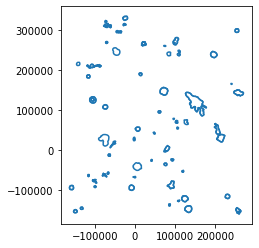

In [1298]:
import geopandas
gg = geopandas.GeoDataFrame(geometry=[a.as_shapely() for a in closed_arcs])
gg.plot()

gg.to_file("closed_arcs.gpkg", layer="closed", driver="GPKG")

In [1299]:
def replace_arc_in_polygon(polygon, original_arc, new_arc, invert=False):
    for item in polygon.arcs:
        for row in item:
            if row[0] == original_arc:
                print(f"old {item}")
                row[0] = new_arc
                
                if invert:
                    row[1] = not row[1]
                    
                print(f"new {item}")
            


In [1300]:
import itertools
newarcs = []
total = 0

duplicated = []
for arc, arc2, in itertools.combinations(arcs, 2):
    
        inverted = False
        replace = False
        if np.all(arc.real_points == arc2.real_points):
            duplicated.append(arc)
            replace = True
            
        elif np.all(arc.real_points == arc2.real_points[::-1]):
            
            duplicated.append(arc)
            inverted = True
            replace=True
            
#         elif np.all(arc.real_points[[0,-1]] == arc2.real_points[[0,-1]]):
#             print("shallow eq")
#             replace=True
            
#         elif np.all(arc.real_points[[0,-1]] == arc2.real_points[[0,-1]][::-1]):
#             print("shallow eq, inverted")
#             replace=True
#             inverted=True
            
        if replace:
            for pol in arc.separating_polygons:
                total +=1
                replace_arc_in_polygon(pol, arc, arc2, inverted)
            
            
            
            
            
            
            
print(total)                

<ipython-input-1300-b980760156e6>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(arc.real_points == arc2.real_points):
<ipython-input-1300-b980760156e6>:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif np.all(arc.real_points == arc2.real_points[::-1]):


old [[Arc(id=4) False]]
new [[Arc(id=73) True]]
old [[Arc(id=8) False]]
new [[Arc(id=889) True]]
old [[Arc(id=9) False]]
new [[Arc(id=582) True]]
old [[Arc(id=11) False]]
new [[Arc(id=555) True]]
old [[Arc(id=12) False]]
new [[Arc(id=141) True]]
old [[Arc(id=19) False]]
new [[Arc(id=1219) True]]
old [[Arc(id=37) False]]
new [[Arc(id=1343) True]]
old [[Arc(id=38) False]]
new [[Arc(id=525) True]]
old [[Arc(id=41) False]]
new [[Arc(id=1463) True]]
old [[Arc(id=49) False]]
new [[Arc(id=1173) True]]
old [[Arc(id=50) False]]
new [[Arc(id=1174) True]]
old [[Arc(id=62) False]]
new [[Arc(id=599) True]]
old [[Arc(id=69) False]]
new [[Arc(id=1177) True]]
old [[Arc(id=72) False]]
new [[Arc(id=702) True]]
old [[Arc(id=74) False]]
new [[Arc(id=698) True]]
old [[Arc(id=86) False]]
new [[Arc(id=142) True]]
old [[Arc(id=120) False]]
new [[Arc(id=719) True]]
old [[Arc(id=121) False]]
new [[Arc(id=438) True]]
old [[Arc(id=124) False]]
new [[Arc(id=451) True]]
old [[Arc(id=125) False]]
new [[Arc(id=920) T

In [1301]:
used_arcs = []
for pol in polygons:
    for ring in pol.arcs:
        for arc, ori in ring:
            if arc not in used_arcs:
                used_arcs.append(arc)
asarcs = used_arcs         
used_arcs = [arc.as_shapely() for arc in used_arcs]            

In [1302]:
geopandas.GeoDataFrame(geometry=used_arcs).to_file("used_lines.gpkg", driver="GPKG", layer="used")

In [1303]:
total = 0
intersecting = []

for arc1, arc2, in itertools.combinations(asarcs, 2):
    a1 = arc1.as_shapely()
    a2 = arc2.as_shapely()
    
    if a1.intersects(a2):
        ints = a1.intersection(a2)
        if isinstance(ints, (shapely.geometry.Point, shapely.geometry.MultiPoint)):
            continue
        else:
            total +=1
            intersecting.append([arc1, arc2, ints])
            
print(total)

31


In [1304]:
intersecting

[[Arc(id=30),
  Arc(id=585),
 [Arc(id=30),
  Arc(id=1429),
 [Arc(id=54),
  Arc(id=513),
 [Arc(id=56),
  Arc(id=514),
 [Arc(id=58),
  Arc(id=547),
 [Arc(id=59),
  Arc(id=1218),
 [Arc(id=70),
  Arc(id=1059),
 [Arc(id=84),
  Arc(id=684),
 [Arc(id=85),
  Arc(id=684),
 [Arc(id=93),
  Arc(id=1351),
 [Arc(id=119),
  Arc(id=753),
 [Arc(id=156),
  Arc(id=828),
 [Arc(id=159),
  Arc(id=826),
 [Arc(id=160),
  Arc(id=261),
 [Arc(id=160),
  Arc(id=822),
 [Arc(id=247),
  Arc(id=834),
 [Arc(id=251),
  Arc(id=835),
 [Arc(id=281),
  Arc(id=1067),
 [Arc(id=283),
  Arc(id=1068),
 [Arc(id=347),
  Arc(id=1065),
 [Arc(id=348),
  Arc(id=1381),
 [Arc(id=356),
  Arc(id=1203),
 [Arc(id=407),
  Arc(id=618),
 [Arc(id=410),
  Arc(id=601),
 [Arc(id=435),
  Arc(id=752),
 [Arc(id=468),
  Arc(id=734),
 [Arc(id=528),
  Arc(id=1325),
 [Arc(id=789),
  Arc(id=1163),
 [Arc(id=1036),
  Arc(id=1221),
 [Arc(id=1045),
  Arc(id=1351),
 [Arc(id=1386),
  Arc(id=1427),

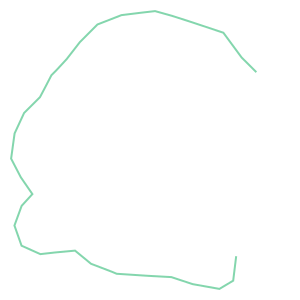

In [1305]:
intersecting[0][0].as_shapely()

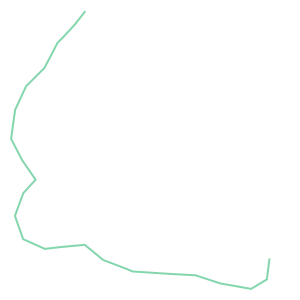

In [1306]:
intersecting[0][1].as_shapely()